In [1]:
# Imports
from transformers import pipeline
from datasets import list_datasets

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/2x/gzdlt84j28z3bbf5yt61tjwr0000gn/T/ipykernel_78478/2305095611.py:4: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 129788 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [2]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 129788 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [ ]:
from datasets import load_dataset

emotions = load_dataset("emotion")

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions.get("train")

In [7]:
len(train_ds)

16000

In [8]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
type(train_ds)

datasets.arrow_dataset.Dataset

In [10]:
train_ds.column_names

['text', 'label']

In [11]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [12]:
emotions.set_format(type="pandas")

In [34]:
df = emotions["train"][:]
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [16]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Looking at the Class Distribution
Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

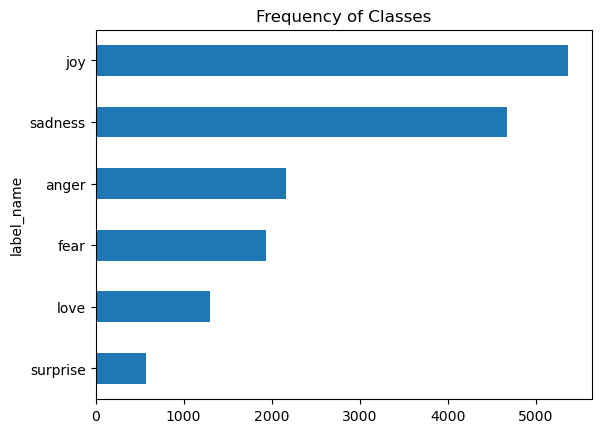

In [27]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and surprise are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

        Randomly oversample the minority class.

        Randomly undersample the majority class.

        Gather more labeled data from the underrepresented classes.

To keep things simple, we’ll work with the raw, unbalanced class frequencies.

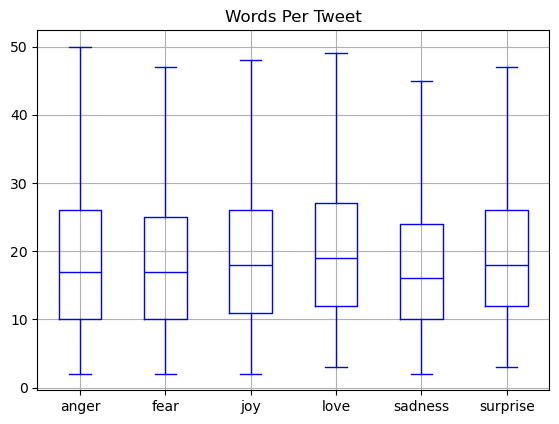

In [33]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=True,
          showfliers=False, color="blue")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [38]:
emotions.reset_format()

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text.

## Tokenization

Subword Tokenization
The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms.

In [35]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 72.9kB/s]
config.json: 100%|██████████| 483/483 [00:00<00:00, 792kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 2.52MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 2.01MB/s]


In [36]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [40]:
print(tokenize(emotions["train"][2]))

{'input_ids': [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [41]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 39575.81 examples/s]


By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we’ve set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new input_ids and attention_mask columns to the dataset:

In [42]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [43]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [45]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors: 100%|██████████| 268M/268M [00:05<00:00, 52.8MB/s] 


In [46]:
device

device(type='cpu')